### Bollinger Bands

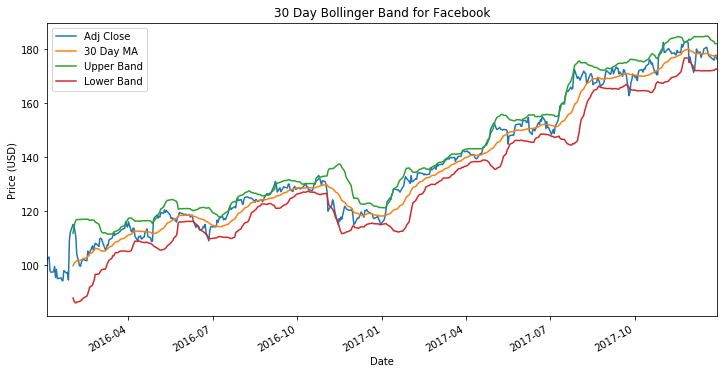

In [3]:
# import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web

# Make function for calls to Yahoo Finance
def get_adj_close(ticker, start, end):
    '''
    A function that takes ticker symbols, starting period, ending period
    as arguments and returns with a Pandas DataFrame of the Adjusted Close Prices
    for the tickers from Yahoo Finance
    '''
    start = start
    end = end
    info = web.DataReader(ticker, data_source='yahoo', start=start, end=end)['Adj Close']
    return pd.DataFrame(info)

# Get Adjusted Closing Prices for Facebook, Tesla and Amazon between 2016-2017
fb = get_adj_close('fb', '1/2/2016', '31/12/2017')
tesla = get_adj_close('tsla', '1/2/2016', '31/12/2017')
amazon = get_adj_close('amzn', '1/2/2016', '31/12/2017')

# Calculate 30 Day Moving Average, Std Deviation, Upper Band and Lower Band
for item in (fb, tesla, amazon):
    item['30 Day MA'] = item['Adj Close'].rolling(window=20).mean()
    
    # set .std(ddof=0) for population std instead of sample
    item['30 Day STD'] = item['Adj Close'].rolling(window=20).std() 
    
    item['Upper Band'] = item['30 Day MA'] + (item['30 Day STD'] * 2)
    item['Lower Band'] = item['30 Day MA'] - (item['30 Day STD'] * 2)

# Simple 30 Day Bollinger Band for Facebook (2016-2017)
fb[['Adj Close', '30 Day MA', 'Upper Band', 'Lower Band']].plot(figsize=(12,6))
plt.title('30 Day Bollinger Band for Facebook')
plt.ylabel('Price (USD)')
plt.show();

A chart overlay that shows the upper and lower limits of 'normal' price movements based on the Standard Deviation of prices.

### Chandelier Exit

In [2]:
import numpy
import talib
from logic import MarketTrend from logic import Indicator from logic.candle import Candle
class ChandelierExit(Indicator): def __init__(self):
super(ChandelierExit,self).__init__() self.enter_period = 22
self.C1 = 0.0
self.C2 = 0.0
self._high = []
self._low = []
self._close = []
self.trend = MarketTrend.NONE
def Update(self, datapoint):
if not isinstance(datapoint, Candle): return
# append data to storage self._high.append(datapoint.High) self._low.append(datapoint.Low) self._close.append(datapoint.Close)
if (len(self._high) > self.enter_period): self._high.pop(0)
self._low.pop(0)
self._close.pop(0)
# find H and L enter_period max and min Pmax = max(self._high)
Pmin = min(self._low)
# calculate enter_period Average True Range
ATR = talib.ATR(numpy.array(self._high), numpy.array(self._low), numpy.array(self._close), timeperiod=self.enter_period)[-1]
# Chandelier's Exit
self.C1 = Pmax - 3.0 * ATR self.C2 = Pmin + 3.0 * ATR
self.trend = MarketTrend.NONE
if (self.C1 > datapoint.Close):
self.trend = MarketTrend.EXIT_LONG
if (self.C2 < datapoint.Close):
self.trend = MarketTrend.EXIT_SHORT
def AmountOfDataStillMissing(self):
return max(0, self.enter_period - len(self._high))
def SeenEnoughData(self):
return (self.AmountOfDataStillMissing == 0)

SyntaxError: invalid syntax (<ipython-input-2-2747ca24ead9>, line 3)

Chandelier Exit is based on the Average True Range (ATR) indicator. It is designed to
keep traders in the trend until a defined trend reversal happens. Traders use CE to maximize their returns in a trade and make stop loss exit decisions.

### Ichimoku Cloud

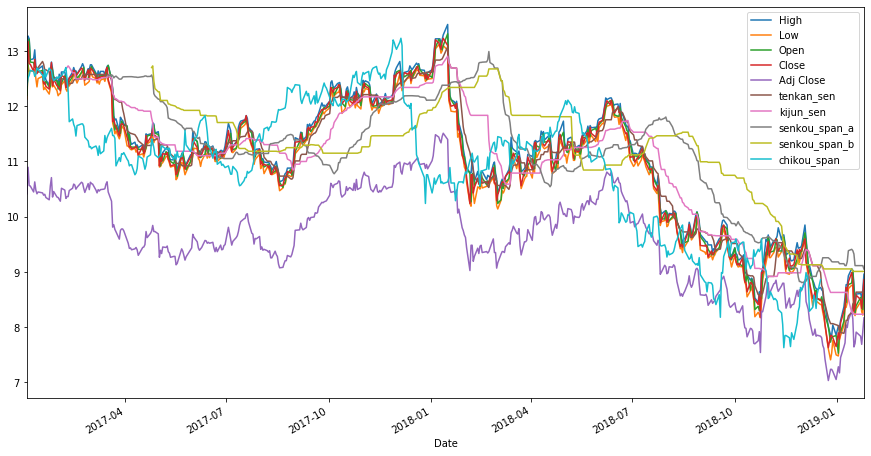

In [10]:
import pandas as pd
from pandas_datareader import data, wb
import matplotlib as mpl
from mpl_finance import candlestick_ohlc
import matplotlib.dates as dates
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2019, 1, 27)
d=data.DataReader("F", 'yahoo', start, end)
# convert dates to integer values for later use with the 
# matplotlib candlestick charting function (it doesn't accept datetimes)
d['Dates'] = dates.date2num(d.index)
# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
nine_period_high = d['High'].rolling(window= 9).max()
nine_period_low = d['Low'].rolling(window= 9).min()
d['tenkan_sen'] = (nine_period_high + nine_period_low) /2
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = d['High'].rolling(window=26).max()
period26_low = d['Low'].rolling(window=26).min()
d['kijun_sen'] = (period26_high + period26_low) / 2
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(26)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = d['High'].rolling(window=52).max()
period52_low = d['Low'].rolling(window=52).min()
d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(26)
# The most current closing price plotted 26 time periods behind (optional)
d['chikou_span'] = d['Close'].shift(-26)
# create a quick plot of the results to see what we have created
d.drop(['Dates', 'Volume'], axis=1).plot(figsize=(15,8))
plt.show()

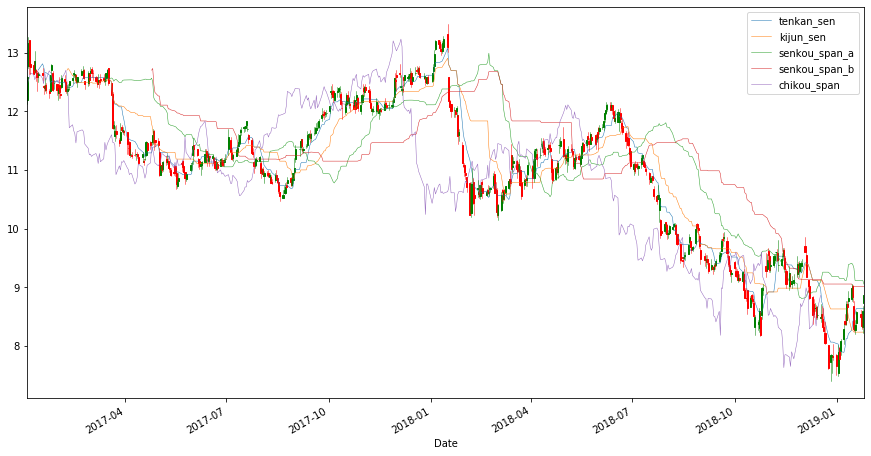

In [11]:
# Re-arrange data so that each row contains values of a day: 'Date','Open','High','Low','Close'.
# The 'Date' can't be a "datetime" object as the function wont accept them. That's why we converted 
# our 'Date' column into integer values using the "date2num" function earlier.
quotes = [tuple(x) for x in d[['Dates','Open','High','Low','Close']].values]
# Plot candlestick, along with Ichimoku elements
fig, ax = plt.subplots(figsize=(15,8))
d[['tenkan_sen','kijun_sen','senkou_span_a','senkou_span_b','chikou_span']].plot(ax=ax, linewidth=0.5)
candlestick_ohlc(ax, quotes, width=1.0, colorup='g', colordown='r');

The Ichimoku Cloud is a collection of technical indicators that show support and
resistance levels, as well as momentum and trend direction. It does this by taking multiple
averages and plotting them on the chart. It also uses these figures to compute a "cloud" which
6 attempts to forecast where the price may find support or resistance in the future.

### Kaufman's Adaptive Moving Average (KAMA)

In [16]:
# Include this line for NEW WINDOW(S) for figures %pylab qt4
# start with getting some data to test on
import datetime
import tradingWithPython as twp # main toolkit functions
import tradingWithPython.lib.yahooFinance as yf # yahoo finance module import tradingWithPython.lib.backtest as backtest
from tradingWithPython.lib.extra import ProgressBar # import progress bar
#The python module (talib) that I will be using to calculate the technical #indicators is a wrapper around the open source TA-Lib.
import talib
import numpy as np
import pandas.io.data as web 
import pandas.stats.moments
import pandas as pd
#pd.set_option('html', False) # how to display data - DEFAULT is True #pd.set_option('display.height', int(1e7)) pd.set_option('display.max_rows', int(1e7)) #pd.set_option('display.max_columns', int(1e7)) pd.set_option('display.width', 3000)
#%%
#%%
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = pandas.stats.moments.rolling_sum(absDiffx,n)
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer
#%%
#Download data from yahoo finance
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2013,12,31)
ticker = "^GSPC" d=web.DataReader(ticker,'yahoo',start,end)
d.info()
#<class 'pandas.core.frame.DataFrame'>
#DatetimeIndex: 1006 entries, 2010-01-04 00:00:00 to 2013-12-31 00:00:00 #Data columns (total 6 columns):
#Open 1006 non-null float64
#High 1006 non-null float64
9
#Low #Close #Volume #Adj Close
1006 non-null float64 1006 non-null float64 1006 non-null int64
1006 non-null float64
type(d) #pandas.core.frame.DataFrame
d.head() d.tail() #%%
#%%
#calculate KAMA
#---------------
kama = KAMA(d.Close, n=10, pow1=2, pow2=30)
type(kama) #pandas.core.frame.DataFrame
kama.head(100) kama.tail(10) #%%
#%%
df = pd.DataFrame({'price':d.Close, 'KAMA':KAMA(d.Close, n=10, pow1=2, pow2=30) }) df.plot(subplots=True)
#%%
#%%
def KAMA(price, n=10, pow1=2, pow2=30):
''' kama indicator '''
''' accepts pandas dataframe of prices '''
absDiffx = abs(price - price.shift(1) )
ER_num = abs( price - price.shift(n) )
ER_den = pandas.stats.moments.rolling_sum(absDiffx,n) ER = ER_num / ER_den
sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0
answer = np.zeros(sc.size) N = len(answer) first_value = True
for i in range(N): if sc[i] != sc[i]:
answer[i] = np.nan
10

else:
if first_value:
answer[i] = price[i]
first_value = False else:
answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1]) return answer
#%%
#%%
#calculate KAMA
#---------------
kama = KAMA(d.Close, n=10, pow1=2, pow2=30) kama
#%%

SyntaxError: invalid syntax (<ipython-input-16-ffa7a0f699f7>, line 47)

A unique moving average that accounts for volatility and automatically adjusts to price
behavior.

### Keltner Channels

A chart overlay that shows upper and lower limits for price movements based on the
9 Average True Range of prices.

In [25]:
import pandas as pd


#Average True Range  
def ATR(df, n):  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'High'), df.get_value(i, 'Close')) - min(df.get_value(i + 1, 'Low'), df.get_value(i, 'Close'))  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(pd.ewma(TR_s, span = n, min_periods = n), name = 'ATR_' + str(n))  
    df = df.join(ATR)  
    return df


#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(pd.rolling_mean((df['High'] + df['Low'] + df['Close']) / 3, n), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(pd.rolling_mean((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3, n), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(pd.rolling_mean((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3, n), name = 'KelChD_' + str(n))  
    df = df.join(KelChM)  
    df = df.join(KelChU)  
    df = df.join(KelChD)  
    return df



#read the data from the csv file
data1 = pd.read_csv('/Users/xl/Documents/Projects/quantstart_backtester_project/TSLA.csv', header=None) 
data1.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker']
data1.shape
#show data

data1=ATR(data1,14)
data1=KELCH(data1,14)
data1.tail()

#plot the Keltner Channels
import matplotlib.pyplot as plt
data1['KelChM_14'].plot(figsize=(12,8));
data1['KelChU_14'].plot(figsize=(12,8));
data1['KelChD_14'].plot(figsize=(12,8));
plt.show()

/Users/xl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Moving Averages

Chart overlays that show the 'average' value over time. Both Simple Moving Averages (SMAs) and Exponential Moving Averages (EMAs) are explained。

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pyEX as pticker = 'AMD'
timeframe = '1y'df = p.chartDF(ticker, timeframe) df = df[['close']]
df.reset_index(level=0, inplace=True) df.columns=['ds','y']plt.plot(df.ds, df.y)
plt.show()
.
# simple moving average
rolling_mean = df.y.rolling(window=20).mean()
rolling_mean2 = df.y.rolling(window=50).mean()
plt.plot(df.ds, df.y, label='AMD') plt.plot(df.ds, rolling_mean, label='AMD 20 Day SMA', color='orange') plt.plot(df.ds, rolling_mean2, label='AMD 50 Day SMA', color='magenta') plt.legend(loc='upper left')
plt.show()
# exponential moving average (EMA)
exp1 = df.y.ewm(span=20, adjust=False).mean()
exp2 = df.y.ewm(span=50, adjust=False).mean()
plt.plot(df.ds, df.y, label='AMD') plt.plot(df.ds, exp1, label='AMD 20 Day EMA')
plt.plot(df.ds, exp2, label='AMD 50 Day EMA')

plt.legend(loc='upper left') 
plt.show()

SyntaxError: invalid syntax (<ipython-input-28-b413dce99371>, line 5)

### Moving Average Envelopes

A chart overlay consisting of a channel formed from simple moving averages. By applying an envelope to the moving average, some of these whipsaw trades can be avoided, and traders can increase their profits.

In [29]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import sys
from . import Indicator, MovingAverage
class EnvelopeMixIn(object): '''
MixIn class to create a subclass with another indicator. The main line of that indicator will be surrounded by an upper and lower band separated a given "perc"entage from the input main line
The usage is:
- Class XXXEnvelope(XXX, EnvelopeMixIn) Formula:
- 'line' (inherited from XXX)) - top = 'line' * (1 + perc)
- bot = 'line' * (1 - perc)
See also: -
http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_average_envelopes '''
lines = ('top', 'bot',)
params = (('perc', 2.5),)
plotlines = dict(top=dict(_samecolor=True), bot=dict(_samecolor=True),)
def __init__(self):
# Mix-in & directly from object -> does not necessarily need super # super(EnvelopeMixIn, self).__init__()
perc = self.p.perc / 100.0
self.lines.top = self.lines[0] * (1.0 + perc) self.lines.bot = self.lines[0] * (1.0 - perc)
super(EnvelopeMixIn, self).__init__()
class _EnvelopeBase(Indicator): lines = ('src',)
# plot the envelope lines along the passed source plotinfo = dict(subplot=False)
# Do not replot the data line
plotlines = dict(src=dict(_plotskip=True))
def __init__(self):
self.lines.src = self.data super(_EnvelopeBase, self).__init__()
class Envelope(_EnvelopeBase, EnvelopeMixIn): '''
It creates envelopes bands separated from the source data by a given percentage
Formula:
- src = datasource
- top = src * (1 + perc) - bot = src * (1 - perc)
See also: -
http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_average_envelopes '''
# Automatic creation of Moving Average Envelope classes
for movav in MovingAverage._movavs[1:]: _newclsdoc = '''
%s and envelope bands separated "perc" from it Formula:
- %s (from %s)
- top = %s * (1 + perc) - bot = %s * (1 - perc)
See also: -
http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_average_envelopes '''
# Skip aliases - they will be created automatically if getattr(movav, 'aliased', ''):
continue
movname = movav.__name__ linename = movav.lines._getlinealias(0)
14
newclsname = movname + 'Envelope'
newaliases = []
for alias in getattr(movav, 'alias', []):
for suffix in ['Envelope']: newaliases.append(alias + suffix)
newclsdoc = _newclsdoc % (movname, linename, movname, linename, linename)
newclsdct = {'__doc__': newclsdoc,
'__module__': EnvelopeMixIn.__module__, '_notregister': True,
'alias': newaliases}
newcls = type(str(newclsname), (movav, EnvelopeMixIn), newclsdct) module = sys.modules[EnvelopeMixIn.__module__]
setattr(module, newclsname, newcls)

IndentationError: expected an indented block (<ipython-input-29-7f22b874ae7c>, line 17)

### Parabolic SAR